## Introduction

Throughout the lectures, we have learned that the symmetries inherent in a machine learning task can be represented through **groups**. Lectures have also delved into the realm of *Group-Convolutional Neural Networks* (**GCNNs**), offering insights into a neural architecture designed to exhibit equivariance to general groups.

In GCNNs, the feature maps function over the elements of the group. However, a straightforward implementation of group-convolution involves computing and storing responses for each group element, making it less practical for networks equivariant to groups with infinite elements.

To overcome this limitation, Steerable CNNs present a more versatile framework. The core principle lies in storing, not the value of a feature map on each group element, but rather the Fourier transform of this feature map, limited to a finite number of frequencies.

This notebook will first introduce Representation theory and Fourier theory (*non-commutative harmonic analysis*), and subsequently delve into how this concept is practically applied to realize Steerable CNNs.

## Prerequisite Knowledge
This notebook will assume familiarity with some concepts of **group theory**, such as *groups*, *group actions* (in particular *on functions*), *semi-direct product* and *order of a group*, as well as basic **linear algebra**.

In [1]:
import torch
import numpy as np
import scipy
import os

np.set_printoptions(precision=3, suppress=True, linewidth=10000, threshold=100000)

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# If the fonts in the plots are incorrectly rendered, comment out the next two lines
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
matplotlib.rcParams['lines.linewidth'] = 2.0

import urllib.request
from urllib.error import HTTPError
from escnn.group import *

CHECKPOINT_PATH = "saved_models/GDL"

/scratch/235010/ipykernel_54027/2968514234.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


## 1. Representation Theory & Harmonic Analysis

Initially, let's establish a group, opting for the *Cyclic Group* $G=C_8$ as our illustration. This group encompasses the $8$ planar rotations achieved through multiples of $\frac{2\pi}{8}$.

Within the escnn framework, groups are represented as instances of the abstract class escnn.group.Group, offering practical functionalities. The instantiation of groups employs a factory method. To craft the cyclic group of order $8$, the following factory method is employed:

In [2]:
G = cyclic_group(N=8)

# We can verify that the order of this group is 8:
G.order()

8

A group is a collection of group elements together with a binary operation to combine them.
This is implemented in the class `escnn.group.GroupElement`.
We can access the *identity* element $e \in G$ as

In [3]:
G.identity

0[2pi/8]

or sample a random element as

In [4]:
G.sample()

4[2pi/8]

Group elements can be combined via the binary operator `@`; we can also take the inverse of an element using `~`:

In [5]:
a = G.sample()
b = G.sample()
print(a)
print(b)
print(a @ b)
print(~a)

0[2pi/8]
6[2pi/8]
6[2pi/8]
0[2pi/8]


Representation theory is a fundamental element in Steerable CNNs and to construct a Fourier theory over groups.
Let's go over the essential concepts.

### 1.1 Group Representation

A **linear group representation** $\rho$ of a compact group $G$ on a vector space (called *representation space*) $\mathbb{R}^d$ is a *group homomorphism* from $G$ to the general linear group $GL(\mathbb{R}^d)$, i.e. it is a map $\rho : G \to \mathbb{R}^{d \times d}$ such that:
$$\rho(g_1 g_2) = \rho(g1) \rho(g2) \quad \forall g_1,g_2 \in G \ .$$

In other words, $\rho(g)$ is a $d \times d$ *invertible* matrix.
We refer to $d$ as the *size* of the representation.

#### Example: the Trivial Representation
The simplest example of *group representation* is the **trivial representation** which maps every element to $1 \in \mathbb{R}$, i.e. $\rho: g \mapsto 1$.
One can verify that it satisfies the condition above.
We can construct this representation as follows:

In [6]:
rho = G.trivial_representation

`rho` is an instance of `escnn.group.Representation`. This class provides some functionalities to work with group representations. We can also use it as a callable function to compute the representation of a group element; this will return a squared matrix as a `numpy.array`.
Let verify that the trivial representation does indeed verify the condition above:

In [7]:
g1 = G.sample()
g2 = G.sample()
print(rho(g1) @ rho(g2))
print(rho(g1 @ g2))

[[1.]]
[[1.]]


Note that the trivial representation has size $1$:

In [8]:
rho.size

1

#### Example: rotations

Another common example of group representations is given by 2D rotations.
Let $SO(2)$ be the group of all planar rotations; note that we can identify each rotation by an angle $\theta \in [0, 2\pi)$.
Then, the standard representation of planar rotations as $2\times 2$ rotation matrices is a representation of $SO(2)$:

$$
    \rho: r_{\theta} \mapsto \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix}
$$

where $r_\theta \in SO(2)$ is a counter-clockwise rotation by $\theta$.
Let's try to build this group and, then, verify that this is a representation:

In [9]:
G = so2_group()
rho = G.standard_representation()

g1 = G.sample()
g2 = G.sample()
print(f'g1={g1}, g2={g2}, g1 * g2 = {g1 @ g2}')
print()
print('rho(g1) @ rho(g2)')
print(rho(g1) @ rho(g2))
print()
print('rho(g1 * g2)')
print(rho(g1 @ g2))

g1=0.8274000416242436, g2=5.034956579836246, g1 * g2 = 5.862356621460489

rho(g1) @ rho(g2)
[[ 0.913  0.409]
 [-0.409  0.913]]

rho(g1 * g2)
[[ 0.913  0.409]
 [-0.409  0.913]]


#### Direct Sum
We can combine representations to build a larger representation via the **direct sum**.

Given representations $\rho_1 : G \to \mathbb{R}^{d_1 \times d_1}$ and $\rho_2 : G \to \mathbb{R}^{d_2 \times d_2}$, their *direct sum* $\rho_1 \oplus \rho_2: G \to \mathbb{R}^{(d_1 + d_2) \times (d_1 + d_2)}$ is defined as

$$
    (\rho_1 \oplus \rho_2)(g) = \begin{bmatrix}\rho_1(g) & 0 \\ 0 & \rho_2(g) \end{bmatrix}
$$

Its action is therefore given by the independent actions of $\rho_1$ and $\rho_2$ on the orthogonal subspaces $\mathbb{R}^{d_1}$ and $\mathbb{R}^{d_2}$  of $\mathbb{R}^{d_1 + d_2}$.

Let's see an example:

In [10]:
rho_sum = rho + rho

g = G.sample()
print(rho(g))
print()
print(rho_sum(g))

[[-0.966 -0.259]
 [ 0.259 -0.966]]

[[-0.966 -0.259  0.     0.   ]
 [ 0.259 -0.966  0.     0.   ]
 [ 0.     0.    -0.966 -0.259]
 [ 0.     0.     0.259 -0.966]]


Note that the direct sum of two representations has size equal to the sum of their sizes:

In [11]:
rho.size, rho_sum.size

(2, 4)

We can combine arbitrary many representations in this way, e.g. $\rho \oplus \rho \oplus \rho \oplus \rho$:

In [12]:
rho_sum = rho + rho + rho + rho

# or, more simply:
rho_sum = directsum([rho, rho, rho, rho])
rho_sum.size

8

#### The Regular Representation

An additional crucial representation is the **regular representation**, which elucidates the impact of a group $G$ on the vector space of functions spanning the group $G$. Let's momentarily assume that the group $G$ is finite, denoted as $|G| < \infty$.

The set of functions over $G$ corresponds to the vector space $\mathbb{R}^{|G|}$. Conceptually, a vector $\mathbf{f} \in \mathbb{R}^{|G|}$ can be construed as a function over $G$, where the $i$-th entry of $\mathbf{f}$ signifies the value of the function at the $i$-th element $g_i \in G$.

$$
[g.f](h) := f(g^{-1} h)
$$

The new function $g.f$ is still a function over $G$ and belongs to the same vector space.
If we represent the function $f$ as a vector $\mathbf{f}$, the vector representing the function $g.f$ will have permuted entries with respect to $\mathbf{f}$.
This permutation is the regular representation of $g \in G$.

For finite groups, we can generate this representation.
We assume that the $i$-th entry is associated with the element of $G=C_8$ corresponing to a rotation by $i \frac{2\pi}{8}$.

In [13]:
G = cyclic_group(8)
rho = G.regular_representation

In [14]:
# note that the size of the representation is equal to the group's order |G|
rho.size

8

the identity element maps a function to itself, so the entries are not permuted

In [15]:
rho(G.identity)

array([[ 1.,  0., -0., -0., -0., -0.,  0., -0.],
       [ 0.,  1.,  0., -0., -0., -0., -0., -0.],
       [-0.,  0.,  1., -0., -0.,  0., -0.,  0.],
       [-0., -0., -0.,  1.,  0., -0., -0., -0.],
       [-0., -0., -0.,  0.,  1.,  0., -0., -0.],
       [-0., -0.,  0., -0.,  0.,  1., -0.,  0.],
       [ 0., -0., -0., -0., -0., -0.,  1., -0.],
       [-0., -0.,  0., -0., -0.,  0., -0.,  1.]])

The regular representation of the rotation by $1\frac{2\pi}{8}$ just cyclically shifts each entry to the next position since $r_{1\frac{2\pi}{8}}^{-1} r_{i\frac{2\pi}{8}} = r_{(i-1)\frac{2\pi}{8}}$:

In [16]:
rho(G.element(1))

array([[ 0., -0.,  0., -0., -0.,  0., -0.,  1.],
       [ 1.,  0., -0., -0., -0., -0.,  0., -0.],
       [ 0.,  1.,  0., -0.,  0., -0., -0., -0.],
       [-0.,  0.,  1., -0., -0.,  0., -0.,  0.],
       [-0., -0., -0.,  1.,  0., -0.,  0., -0.],
       [-0.,  0., -0.,  0.,  1.,  0.,  0., -0.],
       [-0., -0.,  0., -0.,  0.,  1.,  0.,  0.],
       [-0.,  0., -0., -0.,  0., -0.,  1.,  0.]])

Let's see an example of the action on a function.
We consider a function which is zero on all group elements apart from the identity ($i=0$).

In [17]:
f = np.zeros(8)
f[0] = 1
f

array([1., 0., 0., 0., 0., 0., 0., 0.])

Observe that $\rho(e) \mathbf{f} = \mathbf{f}$, where $e = 0\frac{2\pi}{8}$ is the identity element.

In [18]:
rho(G.identity) @ f

array([ 1.,  0., -0., -0., -0., -0.,  0., -0.])

$\mathbf{f}$ is non-zero only on the element $e$.
If an element $g$ acts on this function, it moves the non-zero value to the entry associated with $g$:

In [19]:
rho(G.element(1)) @ f

array([ 0.,  1.,  0., -0., -0., -0., -0., -0.])

In [20]:
rho(G.element(6)) @ f

array([ 0., -0., -0., -0., -0., -0.,  1., -0.])

#### Equivalent Representations

Two representations $\rho$ and $\rho'$ of a group $G$ on the same vector space $\mathbb{R}^d$ are called *equivalent* (or **isomorphic**) if and only if they are related by a change of basis $Q \in \mathbb{R}^{d \times d}$, i.e.
$$ \forall g \in G \quad \rho(g) = Q \rho'(g) Q^{-1} \ . $$

Equivalent representations behave similarly since their composition is *basis-independent* as seen by
$$ \rho'(g_1) \rho'(g_2) = Q \rho(g_1)Q^{−1}Q \rho(g_2)Q^{−1} = Q \rho(g_1)\rho(g_2)Q^{−1} \ .$$

*Direct sum* and *change of basis matrices* provide a way to combine representations to construct larger and more complex representations.
In the next example, we concatenate two trivial representations and two regular representations and apply a random change of basis $Q$.
The final representation is formally defined as:
$$
\rho(g) = Q
\left(
\rho_\text{trivial} \oplus
\rho_\text{regular} \oplus
\rho_\text{regular} \oplus
\rho_\text{trivial}
\right)
Q^{-1}
$$

In [21]:
d = G.trivial_representation.size * 2 + G.regular_representation.size * 2
Q = np.random.randn(d, d)
rho = directsum(
    [G.trivial_representation, G.regular_representation, G.regular_representation, G.trivial_representation],
    change_of_basis=Q
)

In [22]:
rho.size

18

#### Irreducible Representations (or *Irreps*)

Subject to minor conditions, any representation can undergo decomposition in this manner. Specifically, any representation $\rho$ of a compact group $G$ can be expressed as a *direct sum* of several smaller representations, allowing for a change of basis. These so-called "smaller representations" cannot be further decomposed and hold a significant role in the realms of group representations, steerable CNNs, and are denoted as **irreducible representations**, or succinctly, **irreps**.

The set of *irreducible representations* of a group $G$ is generally denoted as $\hat{G}$.
We will often use the notation $\hat{G} = \{\rho_j\}_j$ to index this set.

We can access the irreps of a group via the `irrep()` method.
The *trivial representation* is *always* an irreducible representation.
For $G=C_8$, we access it with the index $j=0$:

In [23]:
rho_0 = G.irrep(0)

print(rho_0 == G.trivial_representation)

rho_0(G.sample())


True


array([[1.]])

The next irrep $j=1$ gives the representation of $i\frac{2\pi}{8}$ as the $2 \times 2$ rotation matrix by $\theta = i\frac{2\pi}{8}$:

In [24]:
rho = G.irrep(1)
g = G.sample()

print(g)
print()
print(rho(g))

2[2pi/8]

[[ 0. -1.]
 [ 1.  0.]]


Irreducible representations provide the building blocks to construct any representation $\rho$ via direct sums and change of basis, i.e:
$$ \rho = Q \left( \bigoplus_{j \in \mathcal{I}} \rho_j \right) Q^{-1} $$

where $\mathcal{I}$ is an index set (possibly with repetitions) over $\hat{G}$.

Internally, any `escnn.group.Representation` is indeed implemented as a list of irreps (representing the index set $\mathcal{I}$) and a change of basis $Q$.
An irrep is identified by a *tuple* `id`.

Let's see an example.
Let's take the regular representaiton of $C_8$ and check its decomposition into irreps:

In [25]:
rho = G.regular_representation
rho.irreps

[(0,), (1,), (2,), (3,), (4,)]

In [26]:
rho.change_of_basis

array([[ 0.354,  0.5  ,  0.   ,  0.5  ,  0.   ,  0.5  ,  0.   ,  0.354],
       [ 0.354,  0.354,  0.354,  0.   ,  0.5  , -0.354,  0.354, -0.354],
       [ 0.354,  0.   ,  0.5  , -0.5  ,  0.   , -0.   , -0.5  ,  0.354],
       [ 0.354, -0.354,  0.354, -0.   , -0.5  ,  0.354,  0.354, -0.354],
       [ 0.354, -0.5  ,  0.   ,  0.5  , -0.   , -0.5  ,  0.   ,  0.354],
       [ 0.354, -0.354, -0.354,  0.   ,  0.5  ,  0.354, -0.354, -0.354],
       [ 0.354, -0.   , -0.5  , -0.5  ,  0.   ,  0.   ,  0.5  ,  0.354],
       [ 0.354,  0.354, -0.354, -0.   , -0.5  , -0.354, -0.354, -0.354]])

In [27]:
# let's access second irrep
rho_id = rho.irreps[1]
rho_1 = G.irrep(*rho_id)

# we verify it is the irrep j=1 we described before
rho_1(g)

array([[ 0., -1.],
       [ 1.,  0.]])

Finally, let's verify that this direct sum and this change of basis indeed yield the regular representation

In [28]:

# evaluate all the irreps in rho.irreps:
irreps = [
          G.irrep(*irrep)(g) for irrep in rho.irreps
]

# build the direct sum
direct_sum = np.asarray(scipy.sparse.block_diag(irreps, format='csc').todense())

print('Regular representation of', g)
print(rho(g))
print()
print('Direct sum of the irreps:')
print(direct_sum)
print()
print('Apply the change of basis on the direct sum of the irreps:')
print(rho.change_of_basis @ direct_sum @ rho.change_of_basis_inv)
print()
print('Are the two representations equal?', np.allclose(rho(g), rho.change_of_basis @ direct_sum @ rho.change_of_basis_inv))


Regular representation of 2[2pi/8]
[[-0.  0. -0. -0.  0. -0.  1.  0.]
 [-0. -0. -0. -0.  0.  0. -0.  1.]
 [ 1.  0. -0. -0. -0. -0.  0. -0.]
 [ 0.  1.  0. -0. -0. -0. -0. -0.]
 [-0.  0.  1. -0. -0.  0. -0.  0.]
 [ 0. -0.  0.  1. -0. -0. -0. -0.]
 [-0. -0. -0.  0.  1.  0. -0. -0.]
 [ 0. -0. -0.  0. -0.  1.  0. -0.]]

Direct sum of the irreps:
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1. -0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -0.  1.  0.]
 [ 0.  0.  0.  0.  0. -1. -0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]

Apply the change of basis on the direct sum of the irreps:
[[-0.  0. -0. -0.  0. -0.  1.  0.]
 [-0. -0. -0. -0.  0.  0. -0.  1.]
 [ 1.  0. -0. -0. -0. -0.  0. -0.]
 [ 0.  1.  0. -0. -0. -0. -0. -0.]
 [-0.  0.  1. -0. -0.  0. -0.  0.]
 [ 0. -0.  0.  1. -0. -0. -0. -0.]
 [-0. -0. -0.  0.  1.  0. -0. -0.]
 [ 0. -0. -0.  0. -0.  1.  0. -0.]]

Are the two representations equal?

### 1.2 Fourier Transform

Now, let's delve into the harmonic analysis of functions over a group. $G$.

It's important to note that a representation  $\rho: G \to \mathbb{R}^{d \times d}$ can be perceived as an assemblage of  $d^2$ functions over the group $G$, one for each matrix entry of $\rho$.
The **Peter-Weyl theorem** asserts that the assortment of functions in the matrix entries of all irreps $\hat{G}$ of a group $G$  forms a basis for the space of all (square-integrable) functions over the group $G$.

This theorem provides a means to parameterize functions over the group, a focal point of this section. Notably, this approach is valuable for parameterizing functions over groups with an infinite number of elements.

We will first look at the *dihedral group* $D_8$ as example.
This is the group containing the $8$ planar rotations by angles multiple of $\frac{2\pi}{8}$ and *reflection* along the $X$ axis.
The group contains in total $16$ elements ($8$ normal rotations and $8$ rotations preceeded by the reflection).

In [29]:
G = dihedral_group(8)
G.order()

16

In [30]:
# element representing the reflection (-) and no rotations
G.reflection

(-, 0[2pi/8])

In [31]:
# element representing a rotation by pi/2 (i.e. 2 * 2pi/8) and no reflections (+)
G.element((0, 2))

(+, 2[2pi/8])

In [32]:
# reflection followed by a rotation by pi/2
print(G.element((0, 2)) @ G.reflection)

# we can also directly generate this element as
print(G.element((1, 2)))

(-, 2[2pi/8])
(-, 2[2pi/8])


In [33]:
# a rotation by pi/2 followed by a reflection is equivalent to a reclection followed by a rotation by 6*2pi/8
G.reflection @ G.element((0, 2))

(-, 6[2pi/8])

The list of all elements in the group is obtaied as:

In [34]:
G.elements

[(+, 0[2pi/8]),
 (+, 1[2pi/8]),
 (+, 2[2pi/8]),
 (+, 3[2pi/8]),
 (+, 4[2pi/8]),
 (+, 5[2pi/8]),
 (+, 6[2pi/8]),
 (+, 7[2pi/8]),
 (-, 0[2pi/8]),
 (-, 1[2pi/8]),
 (-, 2[2pi/8]),
 (-, 3[2pi/8]),
 (-, 4[2pi/8]),
 (-, 5[2pi/8]),
 (-, 6[2pi/8]),
 (-, 7[2pi/8])]

#### Fourier and Inverse Fourier Transform

Usually the irreps constitute a basis for the space of functions, meaning that these functions are mutually orthogonal. 
We can thus write a function $f: G \to \mathbb{R}$ as
$$ f(g) = \sum_{\rho_j \in \hat{G}} \sum_{m,n < d_j} w_{j,m,n} \cdot \sqrt{d_j} [\rho_j(g)]_{mn}$$

where $d_j$ is the dimension of the irrep $\rho_j$, while $m, n$ index the $d_j^2$ entries of $\rho_j$.
The coefficients $\{ w_{j, m, n} \in \mathbb{R} \}_{j, m, n}$ parameterize the function $f$ on this basis.
The $\sqrt{d_j}$ is a scalar factor to ensure normalization of the basis.

We can refine this expression by considering the following fact.
If $A, B \in \mathbb{R}^{d \times d}$, then
$$\text{Tr}(A^T B) = \sum_{m, n < d} A_{mn} B_{mn} \in \mathbb{R} \ .$$

By definining $\hat{f}(\rho_j) \in \mathbb{R}^{d_j \times d_j}$ as the matrix containing the $d_j^2$ coefficients $\{ w_{j, m, n} \in \mathbb{R} \}_{m, n < d_j}$, we can write the **Inverse Fourier Transform** as:
$$ f(g) = \sum_{\rho_j \in \hat{G}} \sqrt{d_j} \text{Tr}\left(\rho_j(g)^T \hat{f}(\rho_j)\right) $$

Similarly, we can project a function $f: G \to \mathbb{R}$ on an element $\rho_{j,m,n}: G \to \mathbb{R}$ of the basis by writing:
$$ w_{j,m,n} = \frac{1}{|G|} \sum_{g \in G} f(g) \sqrt{d_j} [\rho_j(g)]_{m, n} \ . $$

The projection over all entries of $\rho_j$ can be expressed in a more compact way as follows:
$$ \hat{f}(\rho_j) = \frac{1}{|G|} \sum_{g \in G} f(g) \sqrt{d_j} \rho_j(g) \ . $$

which we refer to as **Fourier Transform**.

If $G$ is *infinite*, we instead take an *integral* over the group elements:
$$ \hat{f}(\rho_j) = \int_G f(g) \sqrt{d_j} \rho_j(g) dg \ , $$

For a finite group $G$, we can access all its irreps by using the ``Group.irreps()`` method.
Let's see an example:

In [35]:
irreps = G.irreps()
print(f'The dihedral group D8 has {len(irreps)} irreps')

The dihedral group D8 has 7 irreps


In [36]:
# the first one, is the 1-dimensional trivial representation
print(irreps[0] == G.trivial_representation == G.irrep(0, 0))

True


---

#### <font color='red'>**YOUR CODE HERE:** </font>
Now, we can apply the Fourier Transform and the Inverse Fourier Transform to the Dihedral Group $D_8$. Implement the specified methods using the provided equations:

---

In [37]:
def fourier_transform_D8(f: np.array):
    # the method gets in input a function on the elements of D_8
    # and should return a dictionary mapping each irrep's `id` to the corresponding Fourier Transform
    # The i-th element of `f` stores the value of the function on the group element `G.elements[i]`

    G = dihedral_group(8)
    assert f.shape == (16,), f.shape
    ft = {}

    ########################
    # INSERT YOUR CODE HERE:
    for rho in G.irreps():
        d = rho.size

        rho_g = np.stack([rho(g) for g in G.elements], axis=0)

        ft[rho.id] = (f.reshape(-1, 1, 1) * rho_g).mean(0) * np.sqrt(d)

    ########################

    return ft

In [38]:
def inverse_fourier_transform_D8(ft: dict):
    # the method gets in input a dictionary mapping each irrep's `id` to the corresponding Fourier Transform
    # and should return the function `f` on the elements of D_8
    # The i-th element of `f` stores the value of the function on the group element `G.elements[i]`

    G = dihedral_group(8)
    f = np.zeros(16)

    ########################
    # INSERT YOUR CODE HERE:
    for rho in G.irreps():
        d = rho.size
        for i, g in enumerate(G.elements):
            f[i] += np.sqrt(d) * (ft[rho.id] * rho(g)).sum()


    ########################

    return f

We now want to verify that the **Fourier Transform** and the **Inverse Fourier Transform** are inverse of each other:

In [39]:
f = np.random.randn(16)

ft = fourier_transform_D8(f)

new_f = inverse_fourier_transform_D8(ft)

assert np.allclose(f, new_f)

#### Parameterizing functions over infinite groups
This allows us to also parameterize functions over infinite groups, such as $O(2)$, i.e. the group of all planar rotations and reflections.

In [40]:
G = o2_group()

In [41]:
# the group has infinite many elements, so the `order` method just returns -1
G.order()

-1

The equations remain the same, but this group has an *infinite* number of *irreps*.
We can, however, parameterize a function over the group by only considering a finite number of irreps in the sum inside the definition of *Inverse Fourier Transform*.
Let $\tilde{G} \subset \hat{G}$ be a finite subset of the irreps of $G$.
We can then write the following transforms within the subspace of functions spanned only by the entries of the irreps in $\tilde{G}$.

**Inverse Fourier Transform**:
$$ f(g) = \sum_{\rho_j \in \tilde{G}} \sqrt{d_j} \text{Tr}\left(\rho_j(g)^T \hat{f}(\rho_j)\right) $$

and **Fourier Transform**:
$$ \hat{f}(\rho_j) = \int_G f(g) \sqrt{d_j} \rho_j(g) dg \ , $$


---

#### <font color='red'>**YOUR CODE HERE:** </font>
Now, let's proceed with implementing the Inverse Fourier Transform for the Orthogonal Group $O(2)$. As the group contains infinitely many elements, it's impractical to store values for each element. Instead, we'll sample the function on a specific element of the group.

---

In [42]:
def inverse_fourier_transform_O2(g: GroupElement, ft: dict):
    # the method gets in input a dictionary mapping each irrep's `id` to the corresponding Fourier Transform
    # and a group element `g`
    # The method should return the value of the function evaluated on `g`.

    G = o2_group()
    f = 0

    ########################
    # INSERT YOUR CODE HERE:
    for rho, ft_rho in ft.items():
        rho = G.irrep(*rho)
        d = rho.size
        f += np.sqrt(d) * (ft_rho * rho(g)).sum()

    ########################

    return f

Let's plot a function.
First we generate a random function by using a few irreps.

In [43]:
irreps = [G.irrep(0, 0)] + [G.irrep(1, j) for j in range(3)]

ft = {
    rho.id: np.random.randn(rho.size, rho.size)
    for rho in irreps
}

Next, we create a grid on the group to assess the function, selecting a finite set of elements from $G$. Similar to the Dihedral group, $O(2)$ encompasses rotations (characterized by an angle $\theta \in [0, 2\pi)$) and a reflection followed by any rotation. For instance:

In [44]:
G.sample()

(-, 1.8174442950015706)

To build our grid, we sample $100$ rotations and $100$ rotations preceeded by a reflection:

In [45]:
N = 100
thetas = [i*2*np.pi/N for i in range(N)]
grid_rot = [G.element((0, theta)) for theta in thetas]
grid_refl = [G.element((1, theta)) for theta in thetas]

We now evaluate the function over all these elements and, finally, plot it:

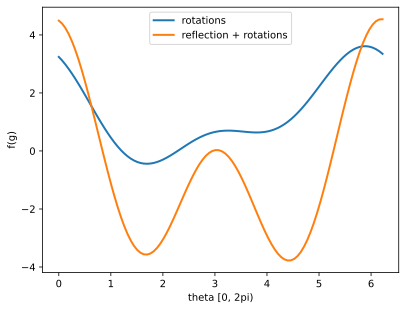

In [46]:
f_rot = [
    inverse_fourier_transform_O2(g, ft) for g in grid_rot
]
f_refl = [
    inverse_fourier_transform_O2(g, ft) for g in grid_refl
]


plt.plot(thetas, f_rot, label='rotations')
plt.plot(thetas, f_refl, label='reflection + rotations')
plt.xlabel('theta [0, 2pi)')
plt.ylabel('f(g)')
plt.legend()
plt.show()

Observe that using more irreps allows one to parameterize more flexible functions.
Let's try to add some more:

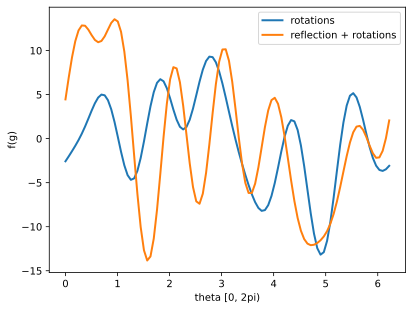

In [47]:
irreps = [G.irrep(0, 0)] + [G.irrep(1, j) for j in range(8)]

ft = {
    rho.id: np.random.randn(rho.size, rho.size)
    for rho in irreps
}

f_rot = [
    inverse_fourier_transform_O2(g, ft) for g in grid_rot
]
f_refl = [
    inverse_fourier_transform_O2(g, ft) for g in grid_refl
]


plt.plot(thetas, f_rot, label='rotations')
plt.plot(thetas, f_refl, label='reflection + rotations')
plt.xlabel('theta [0, 2pi)')
plt.ylabel('f(g)')
plt.legend()
plt.show()

#### Fourier Transform of shifted functions

Recall that a group element $g \in G$ can act on a function $f: G \to \mathbb{R}$ as:
$$ [g.f](h) = f(g^{-1}h) \ .$$

A useful property in our previously defined Fourier Transform is that the transform of $f$ and of $[g.f]$ are related as follows:
$$\widehat{g.f}(\rho_j) = \rho_j(g) \widehat{f} $$

for any irrep $\rho_j$.

We can verify this property visually:

Transforming the function with g=(+, 1.935621323249464)


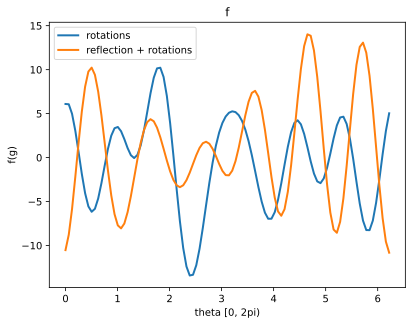

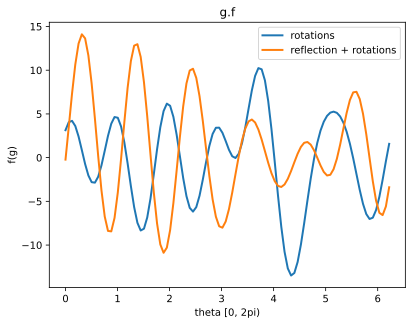

In [48]:
irreps = [G.irrep(0, 0)] + [G.irrep(1, j) for j in range(8)]

# first, we generate a random function, as earlier
ft = {
    rho.id: np.random.randn(rho.size, rho.size)
    for rho in irreps
}

# second, we sample a random group element `g`
g = G.sample()
print(f'Transforming the function with g={g}')

# finally, we transform the Fourier coefficients as in the equations above:
gft = {
    rho.id: rho(g) @ ft[rho.id]
    for rho in irreps
}

# Let's now visualize the two functions:

f_rot = [
    inverse_fourier_transform_O2(g, ft) for g in grid_rot
]
f_refl = [
    inverse_fourier_transform_O2(g, ft) for g in grid_refl
]

gf_rot = [
    inverse_fourier_transform_O2(g, gft) for g in grid_rot
]
gf_refl = [
    inverse_fourier_transform_O2(g, gft) for g in grid_refl
]


plt.plot(thetas, f_rot, label='rotations')
plt.plot(thetas, f_refl, label='reflection + rotations')
plt.xlabel('theta [0, 2pi)')
plt.ylabel('f(g)')
plt.title('f')
plt.legend()
plt.show()

plt.plot(thetas, gf_rot, label='rotations')
plt.plot(thetas, gf_refl, label='reflection + rotations')
plt.xlabel('theta [0, 2pi)')
plt.ylabel('f(g)')
plt.title('g.f')
plt.legend()
plt.show()

#### From the Fourier Transform to the Regular Representation

For simplicity, we can stack all the Fourier coefficients (the output of the Fourier transform, that is, the input of the inverse Fourier transform) into a unique vector.
We define the vector $\mathbf{f}$ as the stack of the columns of each Fourier coefficients matrix $f(\rho_j)$.

Let's first introduce some notation.
We denote the stack of two vectors $\mathbf{v_1}, \mathbf{v_2}$ as $\mathbf{v_1} \oplus \mathbf{v_2}$.
The use of $\oplus$ is not random: if $\rho_1$ is a representation acting on $\mathbf{v_1}$ and $\rho_2$ is a representation acting on $\mathbf{v_2}$, then the *direct sum* $\rho_1 \oplus \rho_2$ acts on the concatenated vector $\mathbf{v_1} \oplus \mathbf{v_2}$.

Second, we denote by $\text{vec}(A)$ the vector which is the stack of the columns of a matrix $A$.
In `numpy`, this is written as `A.T.reshape(-1)`, where the transpose is necessary since `numpy` stacks rows by default.

Then, we write:
$$ \mathbf{f} = \bigoplus_{\rho_j} \text{vec}(\hat{f}(\rho_j)) \ .$$

Moreover, by using $\widehat{g.f}(\rho_j) = \rho_j(g) \hat{f}(\rho_j)$, we see that the vector containing the coefficients of the function $[g.f]$ will be:
$$
\bigoplus_{\rho_j} \text{vec}(\rho_j(g) \hat{f}(\rho_j)) =
\bigoplus_{\rho_j} \left(\bigoplus^{d_j} \rho_j(g)\right) \text{vec}(\hat{f}(\rho_j))
$$

In other words, the group $G$ is acting on the vector $\mathbf{f}$ with the following representation:
$$
\rho(g) = \bigoplus_{\rho_j} \bigoplus^{d_j} \rho_j(g)
$$

i.e. $\rho(g) \mathbf{f}$ is the vector containing the Fourier coefficients of the function $[g.f]$.

Note that, essentially, the representation $\rho$ acts on a vector space containing functions over $G$.
This should remind you of the **regular representation** we defined for *finite groups* earlier.
Indeed, it turns out that, if $G$ is finite, the representation $\rho$ we have just constructed is **isomorphic** (*equivalent*) to the *regular representation* defined earlier.
The change of basis $Q$ is a matrix which performs the Fourier transform, while $Q^{-1}$ performs the inverse Fourier transform.
More formally:
$$ \rho_\text{reg}(g) = Q^{-1} \left(\bigoplus_{\rho_j} \bigoplus^{d_j} \rho_j(g) \right) Q $$

where each irrep $\rho_j$ is repeated $d_j$ times, i.e. a number of times equal to its size.

**Intuition**: recall that a function $f : G \to \mathbb{R}$ is just a vector living in a vector space. Such vector can be expressed with respect to any basis for this vector space. The first time we introduced the *regular representation* for finite groups, we chose a basis where each axis is associated with a group element; the action of $G$ is realized in this basis by a permutation of all the axes. Here, instead, we defined a basis for the same vector space where $G$ acts indipendently on different subsets of the axes, i.e. the action of $G$ is a block-diagonal matrix (the direct sum of irreps). This is often a more convenient choice of basis as we will see later.

Let verify this equivalence for the Dihdral group $D_8$:

In [49]:

G = dihedral_group(8)

rho_irreps = []
for rho_j in G.irreps():
    d_j = rho_j.size
    # repeat each irrep a number of times equal to its size
    rho_irreps += [rho_j]*d_j

rho = directsum(rho_irreps)

print('The representations have the same size:')
print(rho.size, G.regular_representation.size)

print('And contain the same irreps:')
print(rho.irreps)
print(G.regular_representation.irreps)

# Fourier transform matrix:
Q = G.regular_representation.change_of_basis
# inverse Fourier transform matrix:
Qinv = G.regular_representation.change_of_basis_inv

# let's check that the two representations are indeed equivalent
g = G.sample()

rho_g = rho(g)
reg_g = G.regular_representation(g)
print()
print('Are the two representations equivalent?', np.allclose(Q @ rho_g @ Qinv, reg_g))

The representations have the same size:
16 16
And contain the same irreps:
[(0, 0), (1, 0), (1, 1), (1, 1), (1, 2), (1, 2), (1, 3), (1, 3), (1, 4), (0, 4)]
[(0, 0), (1, 0), (1, 1), (1, 1), (1, 2), (1, 2), (1, 3), (1, 3), (1, 4), (0, 4)]

Are the two representations equivalent? True


In cases where $G$ is not finite, storing the regular representation $\rho_\text{reg}$ or the Fourier transform matrix $Q$ explicitly is not feasible due to their infinite dimensionality. However, as previously discussed, we can restrict our consideration to a subset of functions spanned by a finite number of irreps. Sampling the function on any group element using the Inverse Fourier Transform when required allows us to avoid computing the complete Inverse Fourier Transform $Q^{-1}$ and storing all values. 

This concept forms the basis for developing GCNNs equivariant to infinite groups, which we'll explore further later on.

We can easily generate this representation as (`bl_regular_representation` stands for "band-limited", since only a limited subset of irreps, i.e. frequencies, is used):

In [50]:
G = o2_group()

rho = G.bl_regular_representation(7)

rho.irreps

[(0, 0),
 (1, 0),
 (1, 1),
 (1, 1),
 (1, 2),
 (1, 2),
 (1, 3),
 (1, 3),
 (1, 4),
 (1, 4),
 (1, 5),
 (1, 5),
 (1, 6),
 (1, 6),
 (1, 7),
 (1, 7)]

## 2. Steerable CNNs


We consider a GCNN equivariant to a *semi-direct* product group $\mathbb{R}^n \rtimes G$, with compact group $G \leq O(n)$.
This setting covers equivariance to **isometries** (distance preserving transformations) of the Euclidean space $\mathbb{R}^n$; in particular, it includes equivariance to *translations* in $\mathbb{R}^n$ and to a origin-preserving symmetry $G$ (e.g. rotations or reflections in $n$-dimensions).
We call $G$ a **point group**.

If $G=O(n)$, the group of all rotations and reflections in $\mathbb{R}^n$, then $E(n) = \mathbb{R}^n \rtimes O(n)$ is called the **Euclidean group**, and includes all isometries of $\mathbb{R}^n$.

### 2.1 Feature Fields
In a GCNN, a feature map is a signal $f: \mathbb{R}^n \times G \to \mathbb{R}$.
The action of an element $(x, g) \in \mathbb{R}^n \rtimes G$ is:

$$ [(x, g).f](y,h):= f(g^{-1}(y-x), g^{-1}h) $$

where $x, y \in \mathbb{R}^n$ and $g, h \in G$.

In GCNNs, feature maps $f$ are reprsented as multi-dimensional arrays with a dedicated axis for each of the $n$ spatial dimensions and one for the group $G$.

In a steerable CNN, we replace the $G$ axis with a "Fourier" axis, containing $c$ Fourier coefficients used to parameterize a function over $G$, as previously explained.
Let's denote $\rho: G \to \mathbb{R}^{c \times c}$ as the representation of $G$ acting on these $c$ coefficients. This approach is equivalent to a standard GCNN when $G$ is finite (and we have $c = |G|$), but it extends to use with infinite $G$, such as $SO(2)$.

Now, a feature map $f$ can be seen as a vector field on the space $\mathbb{R}^n$, expressed as:
$$ f: \mathbb{R}^n \to \mathbb{R}^c $$

This assigns a $c$-dimensional feature vector $f(x)\in\mathbb{R}^c$ to each spatial position $x\in\mathbb{R}^n$. Such a vector field is termed a **feature vector field**.

The action of $\mathbb{R}^n \rtimes G$ on one such feature vector field is defined as:

$$ [(x, g).f](y):= \rho(g) f(g^{-1}(y-x)) $$

where $x, y \in \mathbb{R}^n$ and $g \in G$.

### General Steerable CNNs
The framework of Steerable CNNs is inherently more general, accommodating any representation $\rho$ of $G$.
Opting for a different $\rho$ typically demands some structural adjustments in the architecture, such as adapting the non-linearity to ensure equivariance. 

Nonetheless, for the sake of simplicity, we'll adhere to the Fourier example in this notebook.


For the remainder of this notebook, let's assume $n=2$ for simplicity. 

This implies, for instance, working with planar images and isometries of the plane (2D rotations or mirroring). The actions of $g \in G=SO(2)$ on two examples of feature vector fields over $\mathbb{R}^2$ are illustrated below. On the left, $\rho$ represents the trivial representation of $SO(2)$ while, on the right, $\rho$ represents $SO(2)$ as $2\times 2$ rotation matrices.

![feature field examples](https://github.com/QUVA-Lab/e2cnn/raw/master/visualizations/feature_fields.png)

### 2.2 Defining a Steerable CNN

We can now proceed with building a Steerable CNN.
First we import some other useful packages.

In [51]:
from escnn import group
from escnn import gspaces
from escnn import nn

First, we must select the group $G$ of point symmetries (reflections and rotations) under consideration. All these choices correspond to subgroups $G\leq O(2)$ of the orthogonal group.

For simplicity, let's start with the *finite* group $G=C_4$, representing the $4$ rotations by angles $\theta \in \big\{0, \frac{\pi}{2}, \pi, \frac{3\pi}{2}\big\}$. We will later expand our examples to an infinite group like $SO(2)$ or $O(2)$.

Recalling that a semi-direct product $\mathbb{R}^2 \rtimes G$ is defined by both $G$ and the action of $G$ on $\mathbb{R}^2$, we determine both the **point group** $G$ and its **action on the space** $\mathbb{R}^2$ by instantiating a subclass of gspace.GSpace. For the rotational action of $G=C_4$ on $\mathbb{R}^2$, this is achieved by:

In [52]:
r2_act = gspaces.rot2dOnR2(N=4)
r2_act

C4_on_R2[(None, 4)]

In [53]:
# we can access the group G as
G = r2_act.fibergroup
G

C4

After defining the symmetry transformation on the base space $\mathbb{R}^2$, the next step is to define the representation $\rho: G \to \mathbb{R}^{c \times c}$ that describes how a **feature vector field** $f : \mathbb{R}^2 \to \mathbb{R}^c$ transforms under the action of $G$. This transformation law for feature fields is implemented by `nn.FieldType`.

We create an instance of nn.FieldType to model a GCNN feature by providing it with the gspaces.GSpace instance and the regular representation of $G=C_4$. A feature field associated with the regular representation $\rho_\text{reg}$ is referred to as a **regular feature field**.

In [54]:
feat_type = nn.FieldType(r2_act, [G.regular_representation])
feat_type

[C4_on_R2[(None, 4)]: {regular (x1)}(4)]

Recall that the regular representation of a finite group $G$ built by `G.regular_representation` is a permutation matrix of shape $|G| \times |G|$:

In [55]:
G.regular_representation(G.sample())

array([[-0., -0.,  1.,  0.],
       [ 0., -0., -0.,  1.],
       [ 1.,  0., -0., -0.],
       [ 0.,  1.,  0., -0.]])

#### Deep Feature spaces
The deep feature spaces of a GCNN typically consist of multiple channels, and similarly, the feature spaces of a steerable CNN can include multiple independent feature fields. This is accomplished through a **direct sum** by stacking multiple copies of $\rho$.

For instance, we can use three copies of the regular representation $\rho_\text{reg}: G \to \mathbb{R}^{|G|}$. The complete feature space is, in this case, represented as a *stacked* field $f: \mathbb{R}^2 \to \mathbb{R}^{3|G|}$, which transforms according to the **direct sum** of three regular representations:

$$
\rho(r_\theta)
    \ =\ \rho_\text{reg}(r_\theta) \oplus \rho_\text{reg}(r_\theta) \oplus \rho_\text{reg}(r_\theta)
    \ =\ \begin{bmatrix}
            \rho_\text{reg}(\theta) & 0 & 0 \\
            0 & \rho_\text{reg}(\theta) & 0 \\
            0 & 0 & \rho_\text{reg}(\theta) \\
          \end{bmatrix}
          \quad\in\ \mathbb{R}^{3|G| \times 3|G|}
$$

We instantiate a `nn.FieldType` composed of $3$ regular representations by passing the full field representation as a list of three regular representations:


In [56]:
# Technically, one can also construct the direct-sum representation G.regular_representation + G.regular_representation + G.regular_representation as done
# before. Passing a list containing 3 copies of G.regular_representation allows for more efficient implementation of certain operations internally.
feat_type = nn.FieldType(r2_act, [G.regular_representation]*3)
feat_type

[C4_on_R2[(None, 4)]: {regular (x3)}(12)]

#### Input Features
In a steerable CNN, each hidden layer has its own transformation law, which the user must specify (equivalent to choosing the number of channels in each layer of a conventional CNN). The *input* and *output* of a steerable CNN are also feature fields, and their type (i.e., transformation law) is typically determined by the inference task.

A common example is that of gray-scale input images. Rotating a gray-scale image involves moving each pixel to a new position without altering their intensity values. The invariance of scalar pixel values under rotations is modeled by the **trivial representation** $\rho_0: G\to\mathbb{R},\ g\mapsto 1$ of $G$ and identifies them as **scalar fields**. Formally, a scalar field is a function $f: \mathbb{R}^2 \to \mathbb{R}$ mapping to a feature vector with $c=1$ channel. A rotation $r_\theta \in C_4$ transforms this scalar field as:

$$ \big[r_{\theta}\,. f\big](x)
   \ :=\ \rho_0(r_\theta)\,f\big(r_\theta^{-1}x\big)
   \ =\ 1\cdot f\big(r_\theta^{-1}x\big)
   \ =\ f\big(r_\theta^{-1}x\big) \ .
$$


We instantiate the `nn.FieldType` modeling a gray-scale image by passing it the trivial representation of $G$:

In [57]:
feat_type_in = nn.FieldType(r2_act, [G.trivial_representation])
feat_type_in

[C4_on_R2[(None, 4)]: {irrep_0 (x1)}(1)]

#### Equivariant Layers

When constructing a model that is **equivariant** to a group $G$, we demand that the output generated by the model transforms consistently when the input undergoes a transformation by an element $g \in G$. For a function $F$ (such as a neural network), the **equivariance constraint** entails:

$$ \mathcal{T}^\text{out}_g \big[F(x)\big]\ =\ F\big(\mathcal{T}^\text{in}_g[x]\big) \quad \forall g\in G$$

where $\mathcal{T}^\text{in}_g$ represents the transformation of the input by the group element $g$, and $\mathcal{T}^\text{out}_g$ is the transformation of the output by the same element. The *field type* `feat_type_in` we defined above precisely describes $\mathcal{T}^\text{in}$. The transformation law $\mathcal{T}^\text{out}$ for the output of the first layer is similarly chosen by defining an instance `feat_type_out` of `nn.FieldType`.

For instance, let's utilize $3$ *regular feature fields* in the output:

In [58]:
feat_type_out = nn.FieldType(r2_act, [G.regular_representation]*3)

As a shortcut, we can also use:

In [59]:
feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_out = nn.FieldType(r2_act, [r2_act.regular_repr]*3)

Once we have defined how the input and output feature spaces should transform, we can construct neural network functions as **equivariant modules**. These are implemented as subclasses of an abstract base class `nn.EquivariantModule`, which itself inherits from `torch.nn.Module`.

**Equivariant Convolution Layer**: We begin by creating a convolutional layer that maps between fields of types `feat_type_in` and `feat_type_out`.

Let $\rho_\text{in}: G \to \mathbb{R}^{c_\text{in} \times c_\text{in}}$ and $\rho_\text{out}: G \to \mathbb{R}^{c_\text{out} \times c_\text{out}}$ be the representations of $G$ associated with `feat_type_in` and `feat_type_out`, respectively. Then, an equivariant convolution layer is a standard convolution layer with a filter $k: \mathbb{R}^2 \to \mathbb{R}^{c_\text{out} \times c_\text{in}}$ (note the number of input and output channels) that satisfies a specific **steerability constraint**:
$$
\forall g \in G, x \in \mathbb{R}^2 \quad k(g.x) = \rho_\text{out}(g) k(x) \rho_\text{in}(g)^{-1}
$$

In particular, the use of convolution guarantees translation equivariance, while the fact that the filters satisfy this steerability constraint guarantees $G$-equivariance.


The steerability constraint restricts the space of possible learnable filters to a smaller space of equivariant filters.
Solving this constraint goes beyond the scope of this assignment; fortunately, the `nn.R2Conv` module takes care of properly parameterizing the filter $k$ such that it satisfies the constraint.

In [60]:
conv = nn.R2Conv(feat_type_in, feat_type_out, kernel_size=3)

Each equivariant module has an input and output type.
As a function (`.forward()`), it *requires* its inputs to transform according to its input type and is guaranteed to return feature fields associated with its output type.
To prevent the user from accidentally feeding an incorrectly transforming input field into an equivariant module, we perform a dynamic type checking.
In order to do so, we define **geometric tensors** as data containers.
They are wrapping a *PyTorch* `torch.Tensor` to augment them with an instance of `FieldType`.

Let's build a few random 32x32 gray-scale images and wrap them into an `nn.GeometricTensor`:

In [61]:
x = torch.randn(4, 1, 32, 32)
# FieldType is a callable object; its call method can be used to wrap PyTorch tensors into GeometricTensors
x = feat_type_in(x)

assert isinstance(x.tensor, torch.Tensor)
assert isinstance(x, nn.GeometricTensor)

As usually done in *PyTorch*, an image or feature map is stored in a 4-dimensional array of shape BxCxHxW, where B is the batch-size, C is the number of channels and W and H are the spatial dimensions.

We can feed a geometric tensor to an equivariant module as we feed normal tensors in *PyTorch*'s modules:

In [62]:
y = conv(x)

We can verify that the output is indeed associated with the output type of the convolutional layer:

In [63]:
assert y.type == feat_type_out

Lets check whether the output transforms as described by the output type when the input transforms according to the input type.
The $G$-transformation of a geometric tensor is hereby conveniently done by calling `nn.GeometricTensor.transform()`.

In [64]:
# for each group element
for g in G.elements:
    # transform the input with the current group element according to the input type
    x_transformed = x.transform(g)

    # feed the transformed input in the convolutional layer
    y_from_x_transformed = conv(x_transformed)

    # the result should be equivalent to rotating the output produced in the
    # previous block according to the output type
    y_transformed_from_x = y.transform(g)
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g

Any network operation is required to be equivariant. `escnn.nn` provides a wide range of equivariant network modules that guarantee this behavior.

**Non-Linearities**:
As an example, let's apply an *equivariant nonlinearity* to the output feature field of the convolution. Since the regular representations of a finite group $G$ consist of permutation matrices, any pointwise nonlinearity like *ReLUs* is equivariant. Note that this is *not* the case for many other choices of representations / field types!

We instantiate a `escnn.nn.ReLU`, which, as an `nn.EquivariantModule`, requires information about its input type for type checking. Here, we pass `feat_type_out`, the output of the equivariant convolution layer, as the input type. It is not necessary to pass an output type to the nonlinearity since it is determined by its input type.

In [65]:
relu = nn.ReLU(feat_type_out)

z = relu(y)

We can verify the equivariance again:

In [66]:
# for each group element
for g in G.elements:
    y_transformed = y.transform(g)
    z_from_y_transformed = relu(y_transformed)

    z_transformed_from_y = z.transform(g)

    assert torch.allclose(z_from_y_transformed.tensor, z_transformed_from_y.tensor, atol=1e-5), g

**Deeper Models**: In *deep learning*, we typically stack multiple layers to construct a deep model. As long as each layer is equivariant and consecutive layers are compatible, the equivariance property is preserved by induction.

The compatibility of two consecutive layers necessitates the output type of the first layer to be equal to the input type of the second layer.

If we attempt to feed an input with the wrong type to a module, an error will be raised:

In [67]:
layer1 = nn.R2Conv(feat_type_in, feat_type_out, kernel_size=3)
layer2 = nn.ReLU(feat_type_in) # the input type of the ReLU should be the output type of the convolution

x = feat_type_in(torch.randn(3, 1, 7, 7))

try:
    y = layer2(layer1(x))
except AssertionError as e:
    print(e)

Error! the type of the input does not match the input type of this module


Simple deeper architectures can be built using a **SequentialModule**:

In [68]:
feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_hid = nn.FieldType(r2_act, 8*[r2_act.regular_repr])
feat_type_out = nn.FieldType(r2_act, 2*[r2_act.regular_repr])

model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid, inplace=True),
    nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid, inplace=True),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
).eval()


As every layer is equivariant and consecutive layers are compatible, the whole model is equivariant.

In [69]:
x = torch.randn(1, 1, 17, 17)
x = feat_type_in(x)

y = model(x)

# for each group element
for g in G.elements:
    x_transformed = x.transform(g)
    y_from_x_transformed = model(x_transformed)

    y_transformed_from_x = y.transform(g)

    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g

**Invariant Pooling Layer**: Usually, at the end of the model we want to produce a single feature vector to use for classification.
To do so, it is common to pool over the spatial dimensions, e.g. via average pooling.

This produces (approximatively) translation-invariant feature vectors.

In [70]:
# average pooling with window size 11
avgpool = nn.PointwiseAvgPool(feat_type_out, 11)

y = avgpool(model(x))

print(y.shape)

torch.Size([1, 8, 1, 1])


In our case, the feature vectors $f(x)\in\mathbb{R}^c$ associated to each point $x\in\mathbb{R}^2$ have a well defined transformation law.
The output of the model now transforms according to `feat_type_out` (here two $C_4$ regular fields, i.e. 8 channels).
For our choice of regular representations (which are permutation representations) the channels in the feature vectors associated to each point permute when the input is rotated.

In [71]:
for g in G.elements:
    print(f'rotation by {g}:', y.transform(g).tensor[0, ...].detach().numpy().squeeze())

rotation by 0[2pi/4]: [-0.158 -0.19  -0.119 -0.187  0.207  0.217  0.221  0.235]
rotation by 1[2pi/4]: [-0.187 -0.158 -0.19  -0.119  0.235  0.207  0.217  0.221]
rotation by 2[2pi/4]: [-0.119 -0.187 -0.158 -0.19   0.221  0.235  0.207  0.217]
rotation by 3[2pi/4]: [-0.19  -0.119 -0.187 -0.158  0.217  0.221  0.235  0.207]


Many learning tasks require to build models which are **invariant** under rotations.
We can compute invariant features from the output of the model using an **invariant map**.
For instance, we can take the maximum value within each regular field.
We do so using `nn.GroupPooling`:

In [72]:
invariant_map = nn.GroupPooling(feat_type_out)

y = invariant_map(avgpool(model(x)))

for g in G.elements:
    print(f'rotation by {g}:', y.transform(g).tensor[0, ...].detach().numpy().squeeze())

rotation by 0[2pi/4]: [-0.119  0.235]
rotation by 1[2pi/4]: [-0.119  0.235]
rotation by 2[2pi/4]: [-0.119  0.235]
rotation by 3[2pi/4]: [-0.119  0.235]


In [73]:
# for each group element
for g in G.elements:
    # rotated the input image
    x_transformed = x.transform(g)
    y_from_x_transformed = invariant_map(avgpool(model(x_transformed)))

    y_transformed_from_x = y # no .transform(g) needed since y should be invariant!

    # check that the output did not change
    # note that here we are not rotating the original output y as before
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-6), g

### 2.3 Steerable CNN with infinite group $G$

We can now repeat the same constructions with $G$ being an infinite group, e.g. the group of all planar rotations $G=SO(2)$.

In [74]:
# use N=-1 to indicate all rotations
r2_act = gspaces.rot2dOnR2(N=-1)
r2_act

SO(2)_on_R2[(None, -1)]

In [75]:
G = r2_act.fibergroup
G

SO(2)

In [76]:
# For simplicity we take a single-channel gray-scale image in input and we output a single-channel gray-scale image, i.e. we use scalar fields in input and output
feat_type_in = nn.FieldType(r2_act, [G.trivial_representation])
feat_type_out = nn.FieldType(r2_act, [G.trivial_representation])

For intermediate feature types, we want to again use the *regular representation*. Because $G$ has an infinite number of elements, we can employ the Fourier transform idea described earlier. For instance, we will use the first three irreps of $G=SO(2)$, which contain cosines and sines of frequencies $0$, $1$, and $2$. Earlier, we constructed this representation as:

```python
rho = G.bl_regular_representation(2)
```

To apply a non-linearity, such as ELU, we can use the *Inverse Fourier Transform* to sample the function, apply the non-linearity, and finally, compute the *Fourier Transform* to recover the coefficients. Since $G$ has an infinite number of elements, the Fourier Transform requires an integral over $G$, which can be **approximated** by a sum over a finite number of samples. The more samples one takes, the better the approximation will be, although this also increases the computational cost.

Fortunately, the class `nn.FourierELU` takes care of most of these details. We can simply specify which `irreps` to consider (`G.bl_irreps(2)` returns the list of irreps up to frequency `2`), the number of `channels` (i.e., copies of the regular representation), and the number `N` of elements of $G$ to sample the function:

In [77]:
nonlinearity = nn.FourierELU(r2_act, 16, irreps=G.bl_irreps(2), N=12)
# we do not need to pre-define the feature type: FourierELU will create it internally and we can just access it as
feat_type_hid = nonlinearity.in_type

# note also the its input and output types are the same
assert nonlinearity.in_type == nonlinearity.out_type


#### <font color='red'>**YOUR CODE HERE:** </font>
Let's build a simple $G=SO(2)$ equivariant model:

In [78]:

# equivariant_so2_model = nn.SequentialModule(
#     # Add R2Conv() from .nn module with out_type = feat_type_hid and kernel_size = 7
#     ??,
#     # Add IIDBatchNorm2d() from .nn module
#     ??,
#     # Add nonlinearity
#     ??,
#     # Add R2Conv() from .nn module with out_type = feat_type_hid and kernel_size = 7
#     ??,
#     # Add IIDBatchNorm2d() from .nn module
#     ??,
#     # Add nonlinearity
#     ??,
#     # Add R2Conv() from .nn module with out_type = feat_type_out and kernel_size = 7
#     ??,
# ).eval()

equivariant_so2_model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=7),
    nn.IIDBatchNorm2d(feat_type_hid),
    nonlinearity,
    nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=7),
    nn.IIDBatchNorm2d(feat_type_hid),
    nonlinearity,
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=7),
).eval()

and check its equivariance to a few elements of $SO(2)$:

In [79]:
x = torch.randn(1, 1, 23, 23)
x = feat_type_in(x)

y = equivariant_so2_model(x)

# check equivariance to N=16 rotations
N = 16

try:
    for i in range(N):
        g = G.element(i*2*np.pi/N)
        x_transformed = x.transform(g)
        y_from_x_transformed = equivariant_so2_model(x_transformed)

        y_transformed_from_x = y.transform(g)

        assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-3), g
except:
    print('Error! The model is not equivariant!')

Error! The model is not equivariant!


While the model can not be perfectly equivariant, we can compare it with a *conventional CNN* baseline.
Let's build a CNN similar to our equivariant model but which is not constrained to be equivariant:

In [80]:

conventional_model = torch.nn.Sequential(
    torch.nn.Conv2d(feat_type_in.size, feat_type_hid.size, kernel_size=7),
    torch.nn.BatchNorm2d(feat_type_hid.size),
    torch.nn.ELU(),
    torch.nn.Conv2d(feat_type_hid.size, feat_type_hid.size, kernel_size=7),
    torch.nn.BatchNorm2d(feat_type_hid.size),
    torch.nn.ELU(),
    torch.nn.Conv2d(feat_type_hid.size, feat_type_out.size, kernel_size=7),
).eval()


To compare the two models, we compute their *equivariance error* for a few elements of $G$.
We define the equivariance error of a model $F$ with respect to a group element $g \in G$ and an input $x$ as:
$$
  \epsilon_g(F) = \frac{||F(g.X) - g.F(X)||_2}{||F(x)||_2}
$$

Note that this is a form of *relative* error.
Let's now compute the equivariance error of the two models:

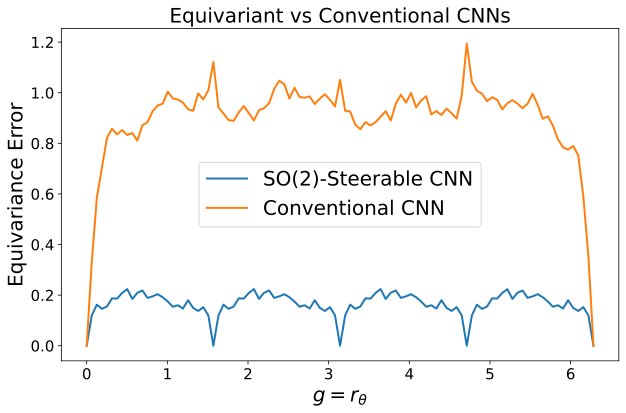

In [81]:
# let's generate a random image of shape W x W
W = 37
x = torch.randn(1, 1, W, W)

# Because a rotation by an angle smaller than 90 degrees moves pixels outsize the image, we mask out all pixels outside the central disk
# We need to do this both for the input and the output

def build_mask(W):
    center_mask = np.zeros((2, W, W))
    center_mask[1, :, :] = np.arange(0, W) - W // 2
    center_mask[0, :, :] = np.arange(0, W) - W // 2
    center_mask[0, :, :] = center_mask[0, :, :].T
    center_mask = center_mask[0, :, :] ** 2 + center_mask[1, :, :] ** 2 < .9*(W // 2) ** 2
    center_mask = torch.tensor(center_mask.reshape(1, 1, W, W), dtype=torch.float)
    return center_mask


# create the mask for the input
input_center_mask = build_mask(W)

# mask the input image
x = x * input_center_mask
x = feat_type_in(x)

# compute the output of both models
y_equivariant = equivariant_so2_model(x)
y_conventional = feat_type_out(conventional_model(x.tensor))

# create the mask for the output images
output_center_mask = build_mask(y_equivariant.shape[-1])

# We evaluate the equivariance error on N=100 rotations
N = 100

error_equivariant = []
error_conventional = []

# for each of the N rotations
for i in range(N+1):
    g = G.element(i / N * 2*np.pi)

    # rotate the input
    x_transformed = x.transform(g)
    x_transformed.tensor *= input_center_mask

    # F(g.X)  feed the transformed images in both models
    y_from_x_transformed_equivariant = equivariant_so2_model(x_transformed).tensor
    y_from_x_transformed_conventional = conventional_model(x_transformed.tensor)

    # g.F(x)  transform the output of both models
    y_transformed_from_x_equivariant = y_equivariant.transform(g)
    y_transformed_from_x_conventional = y_conventional.transform(g)

    # mask all the outputs
    y_from_x_transformed_equivariant = y_from_x_transformed_equivariant * output_center_mask
    y_from_x_transformed_conventional = y_from_x_transformed_conventional * output_center_mask
    y_transformed_from_x_equivariant = y_transformed_from_x_equivariant.tensor * output_center_mask
    y_transformed_from_x_conventional = y_transformed_from_x_conventional.tensor * output_center_mask

    # compute the relative error of both models
    rel_error_equivariant = torch.norm(y_from_x_transformed_equivariant - y_transformed_from_x_equivariant).item() / torch.norm(y_equivariant.tensor).item()
    rel_error_conventional = torch.norm(y_from_x_transformed_conventional - y_transformed_from_x_conventional).item() / torch.norm(y_conventional.tensor).item()

    error_equivariant.append(rel_error_equivariant)
    error_conventional.append(rel_error_conventional)

# plot the error of both models as a function of the rotation angle theta
fig, ax = plt.subplots(figsize=(10, 6))

xs = [i*2*np.pi / N for i in range(N+1)]
plt.plot(xs, error_equivariant, label='SO(2)-Steerable CNN')
plt.plot(xs, error_conventional, label='Conventional CNN')
plt.title('Equivariant vs Conventional CNNs', fontsize=20)
plt.xlabel(r'$g = r_\theta$', fontsize=20)
plt.ylabel('Equivariance Error', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=20)
plt.show()

## 3. Build and Train Steerable CNNs

Finally, we will proceed with implementing a **Steerable CNN** and train it on rotated MNIST.

### Dataset

We will evaluate the model on the *rotated* MNIST dataset.
First, we download the (non-rotated) MNIST 12k data:

In [82]:
# download the dataset
!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist.zip
# uncompress the zip file
!unzip -n mnist.zip -d mnist

--2023-11-24 22:37:00--  http://www.iro.umontreal.ca/~lisa/icml2007data/mnist.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23653151 (23M) [application/zip]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  22.56M  5.18MB/s    in 6.6s    

2023-11-24 22:37:06 (3.43 MB/s) - ‘mnist.zip’ saved [23653151/23653151]

Archive:  mnist.zip
  inflating: mnist/mnist_train.amat  
  inflating: mnist/mnist_test.amat   


Then, we build the dataset and some utility functions:

In [83]:
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from tqdm.auto import tqdm

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/storage/ice-shared/ece8803gdl/env/hw4-p2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [84]:
class MnistDataset(Dataset):

    def __init__(self, mode, rotated: bool = True):
        assert mode in ['train', 'test']

        if mode == "train":
            file = "mnist/mnist_train.amat"
        else:
            file = "mnist/mnist_test.amat"

        data = np.loadtxt(file)

        images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)

        # images are padded to have shape 29x29.
        # this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
        pad = Pad((0, 0, 1, 1), fill=0)

        # to reduce interpolation artifacts (e.g. when testing the model on rotated images),
        # we upsample an image by a factor of 3, rotate it and finally downsample it again
        resize1 = Resize(87) # to upsample
        resize2 = Resize(29) # to downsample

        totensor = ToTensor()

        if rotated:
            self.images = torch.empty((images.shape[0], 1, 29, 29))
            for i in tqdm(range(images.shape[0]), leave=False):
                img = images[i]
                img = Image.fromarray(img, mode='F')
                r = (np.random.rand() * 360.)
                self.images[i] = totensor(resize2(resize1(pad(img)).rotate(r, Image.BILINEAR))).reshape(1, 29, 29)
        else:
            self.images = torch.zeros((images.shape[0], 1, 29, 29))
            self.images[:, :, :28, :28] = torch.tensor(images).reshape(-1, 1, 28, 28)

        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)

    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]

        return image, label

    def __len__(self):
        return len(self.labels)


In [85]:
# Set the random seed for reproducibility
np.random.seed(42)

# build the rotated training and test datasets
mnist_train = MnistDataset(mode='train', rotated=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)


mnist_test = MnistDataset(mode='test', rotated=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)

# for testing purpose, we also build a version of the test set with *non*-rotated digits
raw_mnist_test = MnistDataset(mode='test', rotated=False)

### $SO(2)$ equivariant architecture

Let's now create a CNN with equivariance to $SO(2)$.

Given that the inputs are grayscale images, the model's input type remains a *scalar field*. Throughout the intermediate layers, we'll employ *regular fields*, aligning the model with *group-equivariant convolutional neural networks* (GCNNs).

The final classification step is carried out through a fully connected layer.

In [86]:
class SO2SteerableCNN(torch.nn.Module):

    def __init__(self, n_classes=10):

        super(SO2SteerableCNN, self).__init__()

        # the model is equivariant under all planar rotations
        self.r2_act = gspaces.rot2dOnR2(N=-1)

        # the group SO(2)
        self.G: SO2 = self.r2_act.fibergroup

        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])

        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type

        # We need to mask the input image since the corners are moved outside the grid under rotations
        self.mask = nn.MaskModule(in_type, 29, margin=1)

        # convolution 1
        # first we build the non-linear layer, which also constructs the right feature type
        # we choose 8 feature fields, each transforming under the regular representation of SO(2) up to frequency 3
        # When taking the ELU non-linearity, we sample the feature fields on N=16 points
        activation1 = nn.FourierELU(self.r2_act, 8, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation1.in_type
        self.block1 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation1,
        )

        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 16 regular feature fields
        activation2 = nn.FourierELU(self.r2_act, 16, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation2.in_type
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation2
        )
        # to reduce the downsampling artifacts, we use a Gaussian smoothing filter
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 32 regular feature fields
        activation3 = nn.FourierELU(self.r2_act, 32, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation3.in_type
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation3
        )

        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 64 regular feature fields
        activation4 = nn.FourierELU(self.r2_act, 32, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation4.in_type
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation4
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields
        activation5 = nn.FourierELU(self.r2_act, 64, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation5.in_type
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation5
        )

        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields
        activation6 = nn.FourierELU(self.r2_act, 64, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation6.in_type
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation6
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)

        # number of output invariant channels
        c = 64

        # last 1x1 convolution layer, which maps the regular fields to c=64 invariant scalar fields
        # this is essential to provide *invariant* features in the final classification layer
        output_invariant_type = nn.FieldType(self.r2_act, c*[self.r2_act.trivial_repr])
        self.invariant_map = nn.R2Conv(out_type, output_invariant_type, kernel_size=1, bias=False)

        # Fully Connected classifier
        self.fully_net = torch.nn.Sequential(
            torch.nn.BatchNorm1d(c),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(c, n_classes),
        )

    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = self.input_type(input)

        # mask out the corners of the input image
        x = self.mask(x)

        # apply each equivariant block

        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # Each layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)

        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)

        x = self.block5(x)
        x = self.block6(x)

        # pool over the spatial dimensions
        x = self.pool3(x)

        # extract invariant features
        x = self.invariant_map(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor

        # classify with the final fully connected layer
        x = self.fully_net(x.reshape(x.shape[0], -1))

        return x

#### Equivariance Test before training

Let's instantiate the model:

In [87]:
model = SO2SteerableCNN().to(device)

The model is currently initialized with random weights, so we don't anticipate it to yield accurate class probabilities.

Nevertheless, the model should generate identical outputs for rotated versions of the same image. This holds true for rotations by multiples of $\frac{\pi}{2}$ but is only approximate for other angles.

Let's assess it on a random test image: we'll input $N=20$ rotated versions of the first image in the test set and display the model's output logits for each of them.

In [88]:
def test_model_single_image(model: torch.nn.Module, x: torch.Tensor, N: int = 8):
    np.set_printoptions(linewidth=10000)

    x = Image.fromarray(x.cpu().numpy()[0], mode='F')


    # to reduce interpolation artifacts (e.g. when testing the model on rotated images),
    # we upsample an image by a factor of 3, rotate it and finally downsample it again
    resize1 = Resize(87) # to upsample
    resize2 = Resize(29) # to downsample

    totensor = ToTensor()

    x = resize1(x)

    # evaluate the `model` on N rotated versions of the input image `x`
    model.eval()

    print()
    print('##########################################################################################')
    header = 'angle  |  ' + '  '.join(["{:5d}".format(d) for d in range(10)])
    print(header)
    with torch.no_grad():
        for r in range(N):
            x_transformed = totensor(resize2(x.rotate(r*360./N, Image.BILINEAR))).reshape(1, 1, 29, 29)
            x_transformed = x_transformed.to(device)

            y = model(x_transformed)
            y = y.to('cpu').numpy().squeeze()

            angle = r * 360. / N
            print("{:6.1f} : {}".format(angle, y))
    print('##########################################################################################')
    print()


In [89]:
# retrieve the first image from the test set
x, y = next(iter(raw_mnist_test))

# evaluate the model
test_model_single_image(model, x, N=20)


##########################################################################################
angle  |      0      1      2      3      4      5      6      7      8      9
   0.0 : [ 1.883 -0.903  1.225 -0.341  1.81   1.01  -0.188  0.183 -1.214 -0.656]
  18.0 : [ 1.902 -0.907  1.218 -0.345  1.804  1.002 -0.189  0.177 -1.212 -0.667]
  36.0 : [ 1.912 -0.917  1.218 -0.332  1.78   1.003 -0.207  0.186 -1.206 -0.683]
  54.0 : [ 1.93  -0.917  1.229 -0.315  1.789  1.    -0.184  0.171 -1.204 -0.673]
  72.0 : [ 1.925 -0.915  1.231 -0.314  1.804  1.009 -0.185  0.162 -1.219 -0.671]
  90.0 : [ 1.883 -0.903  1.225 -0.341  1.81   1.01  -0.188  0.183 -1.214 -0.656]
 108.0 : [ 1.902 -0.907  1.218 -0.345  1.804  1.002 -0.189  0.177 -1.212 -0.667]
 126.0 : [ 1.912 -0.917  1.218 -0.332  1.78   1.003 -0.207  0.186 -1.206 -0.683]
 144.0 : [ 1.93  -0.917  1.229 -0.315  1.789  1.    -0.184  0.171 -1.204 -0.673]
 162.0 : [ 1.925 -0.915  1.231 -0.314  1.804  1.009 -0.185  0.162 -1.219 -0.671]
 180.0 : [ 1.883 -0

The output of the model is already almost invariant but we observe small fluctuations in the outputs.
This is the effect of the discretization artifacts (e.g. the pixel grid can not be perfectly rotated by any angle without interpolation) and can not be completely removed.

#### Training the model
Let's train the model now.
The procedure is the same used to train a normal *PyTorch* architecture:

In [90]:
# build the training and test function

def test(model: torch.nn.Module):
    # test over the full rotated test set
    total = 0
    correct = 0

    with torch.no_grad():
        model.eval()
        for i, (x, t) in enumerate(test_loader):
            x = x.to(device)
            t = t.to(device)

            y = model(x)

            _, prediction = torch.max(y.data, 1)
            total += t.shape[0]
            correct += (prediction == t).sum().item()
    return correct/total*100.


def train(model: torch.nn.Module, lr=1e-4, wd=1e-4, checkpoint_path: str = None):
    if checkpoint_path is not None:
        checkpoint_path = os.path.join(CHECKPOINT_PATH, checkpoint_path)

    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path))
        model.eval()
        return

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in tqdm(range(21)):
        model.train()
        for i, (x, t) in enumerate(train_loader):
            optimizer.zero_grad()

            x = x.to(device)
            t = t.to(device)

            y = model(x)

            loss = loss_function(y, t)

            loss.backward()

            optimizer.step()
            del x, y, t, loss

        if epoch % 10 == 0:
            accuracy = test(model)
            print(f"epoch {epoch} | test accuracy: {accuracy}")

    if checkpoint_path is not None:
        torch.save(model.state_dict(), checkpoint_path)

Finally, train the $SO(2)$ equivariant model:

In [91]:
# set the seed manually for reproducibility
torch.manual_seed(42)
model = SO2SteerableCNN().to(device)

train(model, checkpoint_path="steerable_so2-pretrained.ckpt")

accuracy = test(model)
print(f"Test accuracy: {accuracy}")

Test accuracy: 94.98400000000001


In [92]:
def test_model_rotations(model: torch.nn.Module, N: int = 24, M: int = 2000, checkpoint_path: str = None):
    # evaluate the `model` on N rotated versions of the first M images in the test set

    if checkpoint_path is not None:
        checkpoint_path = os.path.join(CHECKPOINT_PATH, checkpoint_path)

    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        accuracies = np.load(checkpoint_path)
        return accuracies.tolist()

    model.eval()

    # to reduce interpolation artifacts (e.g. when testing the model on rotated images),
    # we upsample an image by a factor of 3, rotate it and finally downsample it again
    resize1 = Resize(87) # to upsample
    resize2 = Resize(29) # to downsample

    totensor = ToTensor()

    accuracies = []
    with torch.no_grad():
        model.eval()

        for r in tqdm(range(N)):
            total = 0
            correct = 0

            for i in range(M):
                x, t = raw_mnist_test[i]

                x = Image.fromarray(x.numpy()[0], mode='F')

                x = totensor(resize2(resize1(x).rotate(r*360./N, Image.BILINEAR))).reshape(1, 1, 29, 29).to(device)

                x = x.to(device)

                y = model(x)

                _, prediction = torch.max(y.data, 1)
                total += 1
                correct += (prediction == t).sum().item()

            accuracies.append(correct/total*100.)

    if checkpoint_path is not None:
        np.save(checkpoint_path, np.array(accuracies))

    return accuracies

In [93]:
accs_so2 = test_model_rotations(model, 16, 10000, checkpoint_path="steerable_so2-accuracies.npy")

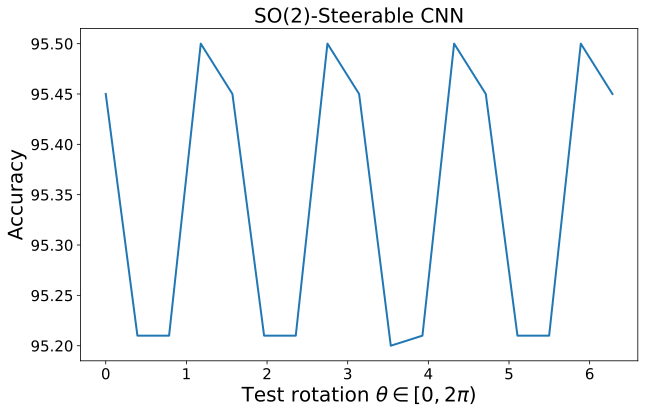

In [94]:
# plot the accuracy of as a function of the rotation angle theta applied to the test set
fig, ax = plt.subplots(figsize=(10, 6))

N = 16

xs = [i*2*np.pi / N for i in range(N+1)]
plt.plot(xs, accs_so2 + [accs_so2[0]])
plt.title('SO(2)-Steerable CNN', fontsize=20)
plt.xlabel(r'Test rotation $\theta \in [0, 2\pi)$', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

Even after training, the model is not perfectly $SO(2)$ equivariant, but we observe the accuracy is rather stable to rotations.

#### $C_4$ equivariant architecture

For comparison, let's build a similar architecture equivariant only to $N=4$ rotations.

In [95]:
class CNSteerableCNN(torch.nn.Module):

    def __init__(self, n_classes=10):

        super(CNSteerableCNN, self).__init__()

        # the model is equivariant to rotations by multiples of 2pi/N
        self.r2_act = gspaces.rot2dOnR2(N=4)

        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])

        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type

        # We need to mask the input image since the corners are moved outside the grid under rotations
        self.mask = nn.MaskModule(in_type, 29, margin=1)

        # convolution 1
        # first we build the non-linear layer, which also constructs the right feature type
        # we choose 8 feature fields, each transforming under the regular representation of C_4
        activation1 = nn.ELU(nn.FieldType(self.r2_act, 8*[self.r2_act.regular_repr]), inplace=True)
        out_type = activation1.in_type
        self.block1 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation1,
        )

        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 16 regular feature fields
        activation2 = nn.ELU(nn.FieldType(self.r2_act, 16*[self.r2_act.regular_repr]), inplace=True)
        out_type = activation2.in_type
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation2
        )
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 32 regular feature fields
        activation3 = nn.ELU(nn.FieldType(self.r2_act, 32*[self.r2_act.regular_repr]), inplace=True)
        out_type = activation3.in_type
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation3
        )

        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 32 regular feature fields
        activation4 = nn.ELU(nn.FieldType(self.r2_act, 32*[self.r2_act.regular_repr]), inplace=True)
        out_type = activation4.in_type
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation4
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 64 regular feature fields
        activation5 = nn.ELU(nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr]), inplace=True)
        out_type = activation5.in_type
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation5
        )

        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields
        activation6 = nn.ELU(nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr]), inplace=True)
        out_type = activation6.in_type
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation6
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)

        # number of output invariant channels
        c = 64

        output_invariant_type = nn.FieldType(self.r2_act, c*[self.r2_act.trivial_repr])
        self.invariant_map = nn.R2Conv(out_type, output_invariant_type, kernel_size=1, bias=False)


        # Fully Connected classifier
        self.fully_net = torch.nn.Sequential(
            torch.nn.BatchNorm1d(c),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(c, n_classes),
        )

    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = self.input_type(input)

        # mask out the corners of the input image
        x = self.mask(x)

        # apply each equivariant block

        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # Each layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)

        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)

        x = self.block5(x)
        x = self.block6(x)

        # pool over the spatial dimensions
        x = self.pool3(x)

        # extract invariant features
        x = self.invariant_map(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor

        # classify with the final fully connected layer
        x = self.fully_net(x.reshape(x.shape[0], -1))

        return x

Instantiate and train the $C_4$ equivariant model:

In [96]:
torch.manual_seed(42)
model_c4 = CNSteerableCNN().to(device)
train(model_c4, checkpoint_path="steerable_c4-pretrained.ckpt")

accuracy = test(model_c4)
print(f"Test accuracy: {accuracy}")

accs_c4 = test_model_rotations(model_c4, 16, 10000, checkpoint_path="steerable_c4-accuracies.npy")

Test accuracy: 93.842


Finally, let's compare the performance of both models on the rotated test sets:

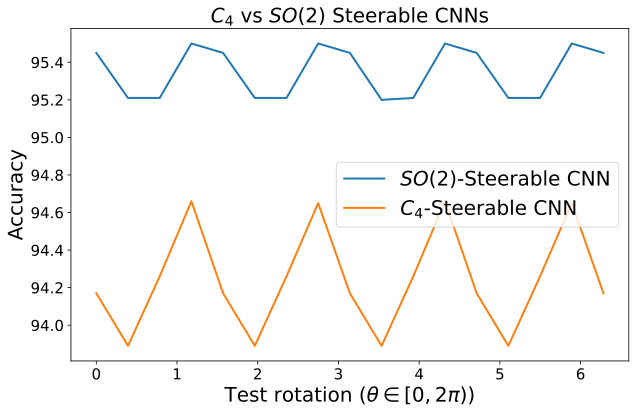

In [97]:
# plot the accuracy of as a function of the rotation angle theta applied to the test set
fig, ax = plt.subplots(figsize=(10, 6))

N=16

xs = [i*2*np.pi / N for i in range(N+1)]
plt.plot(xs, accs_so2 + [accs_so2[0]], label=r'$SO(2)$-Steerable CNN')
plt.plot(xs, accs_c4 + [accs_c4[0]], label=r'$C_4$-Steerable CNN')
plt.title(r'$C_4$ vs $SO(2)$ Steerable CNNs', fontsize=20)

plt.xlabel(r'Test rotation ($\theta \in [0, 2\pi)$)', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=20)
plt.show()

## Congratulations!

In this notebook, you initially delved into *group representation theory* and the *Fourier Transform* over compact groups. These mathematical tools are essential for formalizing Steerable CNNs.

In the second part of the notebook, you explored *steerable feature fields* and *steerable CNNs*. Specifically, the Fourier transform introduced earlier enabled the construction of a steerable CNN that is equivalent to a Group-Convolutional Neural Network (GCNN) equivariant to translations and the continuous group $G=SO(2)$ of rotations.

Throughout our exploration of steerable CNNs, we primarily utilized the *regular representation* of the group $G$. However, it's important to note that the framework of steerable CNNs accommodates various representations.